# Статистический анализ данных по аренде самокатов в сервисе GoFast

**ПОСТАНОВКА ЗАДАЧИ**

Заказчик этого исследования — сервис по прокату самокатов GoFast. 
Нам нужно изучить и проанализировать данные о некоторых пользователях из нескольких городов, которые совершают поездки с использованием сервиса GoFast. На основании этих данных необходимо проверить несколько гипотез о времени поездок, расстоянии, помесячной выручке, и влияние технических обновлений, а также необходимо определить минимальное число промокодов для достижения плана и построить график распределения для оценки открытия push-уведомлений.
Исходные данные: данные, предоставленные сервисом GoFast. Набор данных содержит информацию о пользователях, поездках и подписках на сам сервис. 

**Немного о сервисе GoFast**

Пользователи могут пользоваться сервисом следующими способами:
- без подписки:
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra:
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

**Цель исследования**:
- *проверить 4 гипотезы:*
    1. Пользователи с подпиской тратят в среднем больше времени на поездки, чем пользователи без подписки.
    2. Пользователи в среднее проезжают расстояние меньше 3130 метров.
    3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
    4. Количество обращений в техподдержку значимо снизилось после технического обновления на стороне сервера приложения.


- *и построить 2 распределения для маркетингового отдела:*
    1. Стратегия раздачи промокодов для акции по продлению подписок
    2. Оценка вероятности открытия push-уведомлений в мобильном приложении

**Ход исследования**

Данные от сервиса GoFast мы получим из файлов ` /datasets/users_go.csv (данные о пользователях), /datasets/rides_go.csv (данные о поездках) и /datasets/subscriptions_go.csv (данные о подписках).`. О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных.

Мы проверим данные на ошибки и оценим их влияние на исследование. Затем, на этапе предобработки мы отыщем возможность исправить самые критичные ошибки данных. Далее проведем исследовательский анализ данных и выявим основные закономерности в данных. После этого подготовим данные для проверки гипотез, путем объединение и структурирование в различные датфреймы, а также добавим подсчет выручки. А в завершении приступим к проверке гипотез и построению ряда распределений для маркетингового отдела.

Таким образом, исследование пройдёт в семь этапов:
 1. Обзор данных.
 2. Предобработка данных.
 3. Исследовательский анализ данных
 4. Объединение и структурирование данных 
 5. Подсчет выручки сервисом
 6. Проверка гипотез.
 7. Построение ряда распределений.

## Шаг 1. Загрузка и первичны обзор данных

Импортируем библиотеки pandas, numpy, matplotlib, seaborn и stats. Считаем данные из csv-файлов и сохраним в переменные df_users, df_rides и df_subs соответственно. Путь к файлам: /datasets/users_go.csv (данные о пользователях), /datasets/rides_go.csv (данные о поездках) и /datasets/subscriptions_go.csv (данные о подписках). В качестве разделителя используется знак по умолчанию.

In [1]:
# импорт библиотек
from scipy import stats as st
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# чтение файла с данными и сохранение в df_movies и df_shows
try:
    df_users = pd.read_csv('/datasets/users_go.csv')
    df_rides = pd.read_csv('/datasets/rides_go.csv')
    df_subs = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    df_users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    df_rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    df_subs = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')
    
# Установка опции для отображения всех столбцов
pd.options.display.max_columns = None

# Установка опции отображения максимального числа строк в выводе
# pd.set_option('display.max_rows', None)

Выведем первые 10 строчек датафреймов `df_users, df_rides и df_subs` на экран.

In [3]:
# получение первых 10 cтрок таблицы df_users
display(df_users.head(10))

# получение первых 10 cтрок таблицы df_rides
display(df_rides.head(10))

# получение первых 10 cтрок таблицы df_subs
df_subs.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Согласно документации к данным `df_users` мы имеем 5 столбцов:**
- *`user_id`* — уникальный идентификатор пользователя;
- *`name`* — имя пользователя;
- *`age`* — возраст;
- *`city`* — город;
- *`subscription_type`* — тип подписки (free, ultra).

**Согласно документации к данным `df_rides` мы имеем 4 столбца:**
- *`user_id`* — уникальный идентификатор пользователя;
- *`distance`* — расстояние, которое пользователь проехал в текущей сессии (в метрах);
- *`duration`* — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
- *`date`* — дата совершения поездки.

**Согласно документации к данным `df_subs` мы имеем 4 столбца:**
- *`subscription_type`* — тип подписки;
- *`minute_price`* — стоимость одной минуты поездки по данной подписке;
- *`start_ride_price`* — стоимость начала поездки;
- *`subscription_fee`* — стоимость ежемесячного платежа.

In [4]:
# Общая информация о данных по пользователям
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
# Общая информация о данных по поездкам
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
# Общая информация о данных по подпискам
df_subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Итак, мы имее следующие тип данных:
- `int` - 6 переменных;
- `float` - 2 переменных;
- `object` - 5 переменных.

При этом `user_id` имеем в двух таблицах, тем самым по этому в качестве общего столбца будем использовать его.
Количество значений в столбцах не различается, значит, в данных нет пропущенных значений.
Данные в столбце `df_rides[date]` имеют некоректный формат.

**ВЫВОД:**

В первой главе проекта мы провели следующие действия.

- ***Типы данных:***
    - В данных о пользователях `df_users` есть 5 столбцов, включая уникальный идентификатор пользователя `user_id`, имя пользователя `name`, возраст `age`, город `city` и тип подписки `subscription_type`.
    - В данных о поездках `df_rides` содержатся 4 столбца: уникальный идентификатор пользователя `user_id`, расстояние `distance`, длительность `duration` и дата `date` совершения поездки.
    - В данных о подписках `df_subs` 4 столбца: тип подписки `subscription_type`, стоимость начала поездки `minute_price`, стоимость ежемесячного платежа `subscription_fee` и стоимость начала поездки `start_ride_price`.
- ***Пропущенные значения:*** Нет пропущенных значений в данных. Все столбцы содержат непустые значения.
- ***Данные о подписках:*** Есть два типа подписок: "*free" и "ultra". "Ultra"* подписка имеет нулевую стоимость начала поездки, но включает ежемесячный платеж.
- ***Общие наблюдения:*** Уникальный идентификатор пользователя `user_id` является общим столбцом в данных о пользователях и поездках, что позволяет объединить данные для дальнейшего анализа.

Данные готовы к проведению этапа предобработки.

## Шаг 2. Предобработка данных

### Приведение столба `date` к типу даты pandas.

Поменяем тип данных в столбце `df_rides[data]` на date

In [7]:
# Преобразуем столбец 'df_rides['date']' в тип datetime
df_rides['date'] = pd.to_datetime(df_rides['date'])

# Выведем для проверки значения из столбца df_rides['date']
df_rides['date']

0       2021-01-01
1       2021-01-18
2       2021-04-20
3       2021-08-11
4       2021-08-28
           ...    
18063   2021-11-04
18064   2021-11-16
18065   2021-11-18
18066   2021-11-27
18067   2021-12-29
Name: date, Length: 18068, dtype: datetime64[ns]

**ВЫВОД:** В данном разделе проекта мы преобразовали тип данных для столбца `df_rides['date']` к формату *datetime.* Это позволяет более удобно работать с датами. Применили метод `pd.to_datetime` для преобразования и проверили результаты.

### Создание дополнительных столбцов.

Проверим за какой период у нас имеются данные о поездках. Это необходимо для недопущения искажения анализа из-за возможных аномалий в столбце "длительность". Если данные о поездках охватывают разные года, то, вероятно, необходимо уточнить период времени, который они охватывают. Например, если у нас есть информация за 2021 и 2022 годы, то январь 2021 и январь 2022 могут быть представлены одной и той же цифрой (1) в столбце "длительность", что может привести к искажениям в анализе данных.

In [8]:
# Проверка уникальных значений года в столбце 'date'
df_rides['date'].dt.year.unique()

array([2021])

Данные представлены только за один год, а именно за 2021.

Создадим новый столбец с номером месяца на основе данных столбца `df_rides['date']`

In [9]:
# Для рассчета месяца, применим метод .dt.month и сохраним это в новый столбец df_rides['month']
df_rides['month'] = df_rides['date'].dt.month

# Проверим данные в новом столбце, для этого выведем первые 5 строк
df_rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**ВЫВОД:** В данном разделе проекта мы проверили за какой период у нас имеются данные, а также c помощью метода `dt.month` извлекли номер месяца из `df_rides['date']` и сохранили его в новый столбце `df_rides['month']`.

### Проверка наличие пропущенных значений и дубликатов в датафреймах.

В первой главе при изучении данных, было определено, что пропущенных значений нет. Для проверки этого посчитаем количество пропущенных значений в каждом датафрейме.

In [10]:
# Подсчет пропущенных значений в df_users
print(f'Количество пропущенных значений в df_users: {df_users.isna().sum().sum()}')

# Подсчет пропущенных значений в df_rides
print(f'Количество пропущенных значений в df_rides: {df_rides.isna().sum().sum()}')

# Подсчет пропущенных значений в df_subs
print(f'Количество пропущенных значений в df_subs: {df_subs.isna().sum().sum()}')

Количество пропущенных значений в df_users: 0
Количество пропущенных значений в df_rides: 0
Количество пропущенных значений в df_subs: 0


Проверим наличие явных дубликатов 

In [11]:
# Подсчет количества явных дубликатов в df_users
print(f'Количество явных дубликатов в df_users: {df_users.duplicated().sum()}')

# Подсчет количества явных дубликатов в df_rides
print(f'Количество явных дубликатов в df_rides: {df_rides.duplicated().sum()}')

# Подсчет количества явных дубликатов в df_subs
print(f'Количество явных дубликатов в df_subs: {df_subs.duplicated().sum()}')

Количество явных дубликатов в df_users: 31
Количество явных дубликатов в df_rides: 0
Количество явных дубликатов в df_subs: 0


Согласно полученным данным, в df_users присутствует 31 явный дубликат. Выведем эти дубликаты.

In [12]:
# Вывод дубликатов и их пар в отсортированном виде
print(f"Явные дубликаты в df_users с их парами:")
df_users[df_users.duplicated(keep=False)].sort_values(by='user_id')

Явные дубликаты в df_users с их парами:


,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
1539,43,Стефания,22,Омск,ultra
1563,47,Юрий,28,Тюмень,ultra
...,...,...,...,...,...
1554,1198,Демид,29,Ростов-на-Дону,free
1558,1237,Евгения,23,Тюмень,free
1236,1237,Евгения,23,Тюмень,free
1544,1245,Регина,27,Пятигорск,free


Удалим эти дубликаты

In [13]:
# Удалим явные дубликаты, оставив первую встретившуюся строку
df_users = df_users.drop_duplicates(keep='first')

# Проверим количество явных дубликатов
df_users.duplicated().sum()

0

**ВЫВОД:** В ходе анализа данных обнаружено отсутствие пропущенных значений в датафреймах `df_users, df_rides и df_subs.` В датафрейме df_users было выявлено 31 явный дубликат, который успешно удалён, оставив только первые встретившиеся строки.

### Проверка наличия аномальных значений в датафреймах.

Проверим наличие аномальных значений в датафрейме `df_users`

In [14]:
# Подсчитаем количество аномальных значений в столбце 'user_id'
print(f'Количество аномальных значений в столбце "user_id": {df_users["user_id"].count() - df_users["user_id"].nunique()}')

Количество аномальных значений в столбце "user_id": 0


In [15]:
# Получим уникальные значения имен пользователей, отсортированные по алфавиту
df_users['name'].sort_values().unique()

array(['Агата', 'Аделина', 'Адель', 'Айдар', 'Александр', 'Александра',
       'Алексей', 'Алина', 'Алиса', 'Алия', 'Алла', 'Альберт', 'Альбина',
       'Алёна', 'Амалия', 'Амина', 'Амир', 'Анастасия', 'Анатолий',
       'Ангелина', 'Андрей', 'Анжелика', 'Анна', 'Антон', 'Антонина',
       'Ариана', 'Арина', 'Арсен', 'Арсений', 'Артемий', 'Артур', 'Артём',
       'Богдан', 'Борис', 'Вадим', 'Валентина', 'Валерий', 'Валерия',
       'Варвара', 'Василий', 'Василина', 'Василиса', 'Вера', 'Вероника',
       'Виктор', 'Виктория', 'Виолетта', 'Виталий', 'Виталина', 'Влад',
       'Влада', 'Владимир', 'Владислав', 'Владислава', 'Всеволод',
       'Вячеслав', 'Галина', 'Георгий', 'Герман', 'Глеб', 'Гордей',
       'Григорий', 'Давид', 'Дамир', 'Даниил', 'Данил', 'Данила',
       'Даниэль', 'Дарина', 'Дарья', 'Демид', 'Денис', 'Диана', 'Дмитрий',
       'Ева', 'Евгений', 'Евгения', 'Егор', 'Екатерина', 'Елена',
       'Елизавета', 'Елисей', 'Есения', 'Жанна', 'Зарина', 'Захар',
       'Злата', 

Аномальных значений в столбце "name" не выявлено

In [16]:
# Получим уникальные значения возрастов пользователей, отсортированные по возрастанию
df_users['age'].sort_values().unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43])

Аномальных значений в в столбце "age" не выявлено

In [17]:
# Получим уникальные значения городов пользователей, отсортированные по возрастанию
df_users['city'].sort_values().unique()

array(['Екатеринбург', 'Краснодар', 'Москва', 'Омск', 'Пятигорск',
       'Ростов-на-Дону', 'Сочи', 'Тюмень'], dtype=object)

Аномальных значений в столбце "city" не выявлено

In [18]:
# Получим уникальные значения типа подписки пользователей, отсортированные по возрастанию
df_users['subscription_type'].sort_values().unique()

array(['free', 'ultra'], dtype=object)

Аномальных значений в столбце "subscription_type" не выявлено

Проверим наличие аномальных значений в датафрейме `df_rides`

In [19]:
# Получим уникальные значения расстояния поездок, отсортированные по возрастанию
df_rides['distance'].sort_values().unique()

array([8.55682926e-01, 2.57078689e+00, 4.32950578e+00, ...,
       6.90849134e+03, 7.06600377e+03, 7.21100774e+03])

In [20]:
# Создадим функцию для построения графика
def build_plot(df, column, title, xlabel, ylabel, bins=50, kde=None):
    try:
        # Создаем новый график размером 10x6 дюймов
        plt.figure(figsize=(10, 6))
        
        # Строим гистограмму распределения значений столбца
        # Используем библиотеку seaborn, указываем количество бинов (групп), добавляем KDE (Kernel Density Estimation) для сглаживания
        sns.histplot(df[column], bins=bins, kde=kde, color='skyblue')
        
        # Задаем заголовок графика
        plt.title(title, fontsize=16)
        
        # Задаем подпись оси X
        plt.xlabel(xlabel, fontsize=14)
        
        # Задаем подпись оси Y
        plt.ylabel(ylabel, fontsize=14)
        
        # Отображаем график
        plt.show()
    except Exception as e:
        # Если произошла ошибка при построении графика, возвращаем сообщение об ошибке
        return f"График не может быть построен. Убедитесь, что исходные данные введены корректно. Произошла ошибка: {e}"

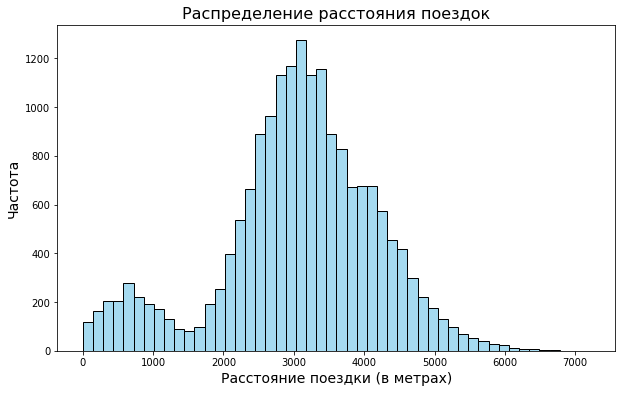

3134.0

In [21]:
build_plot(
    df_rides, 
    'distance', 
    'Распределение расстояния поездок', 
    'Расстояние поездки (в метрах)', 
    'Частота'
)

# Выведем медианное значение 
df_rides['distance'].median().round()

Аномальных значений в столбце "distance" не выявлено, но выявлены 2 пика в распределении в районе 700 и 3200 метров. Основная часть поездок занимает от 2500 до 3800 метров. Медиана распределения равна 3134 метра. Поездки на расстояние более 5 км редки. Однако на гистограмме видно, что некоторая часть пользователей использует самокаты для коротких поездок - до 1500 м.

In [22]:
# Получим уникальные значения продолжительности поездок, отсортированные по возрастанию
df_rides['duration'].sort_values().unique()

array([ 0.5       ,  2.03563247,  2.05325125, ..., 39.52660212,
       39.87385602, 40.82396262])

In [23]:
# Подсчитаем количество уникальных значений продолжительности поездок
df_rides['duration'].nunique()

17974

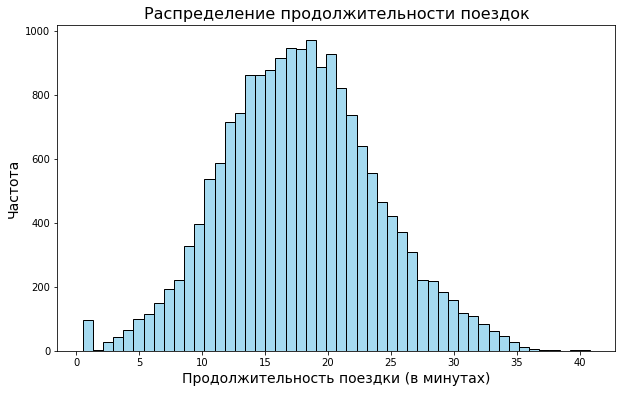

In [24]:
build_plot(
    df_rides, 
    'duration', 
    'Распределение продолжительности поездок', 
    'Продолжительность поездки (в минутах)', 
    'Частота'
)

На графике видно большое количество поездок в районе 0

In [25]:
# Подсчитаем количество значений в столбце 'duration', где продолжительность равна пол минуты
print(f"Количество поездок не более пол минуты: {df_rides['duration'][df_rides['duration'] <= 0.5].count()}")

Количество поездок не более пол минуты: 95


Из более чем 18000 поездок 95 имеют одинаковое значение в пол минуты. Остальные поездки имеют значения больше 2 минут. Данные поездки могли возникнуть как при ошибке в работе приложения, также в следствии алгоритма, который округляет минимальное время пользования поездки до этого значения. Рассмотрим эти данные более подробнее.

In [26]:
# Выберем строки, где продолжительность поездки равна 0.5 минут, и отсортируем по расстоянию
df_rides[df_rides['duration'] == 0.5].sort_values('distance')

,user_id,distance,duration,date,month
15132,1325,4030.308008,0.5,2021-12-22,12
17909,1524,4103.998874,0.5,2021-06-18,6
10692,1006,4106.278268,0.5,2021-10-31,10
9698,937,4169.066800,0.5,2021-12-12,12
14342,1268,4177.139336,0.5,2021-06-09,6
...,...,...,...,...,...
14574,1285,6316.574814,0.5,2021-09-25,9
13701,1224,6414.516026,0.5,2021-07-15,7
11385,1057,6601.197575,0.5,2021-02-07,2
17242,1477,6724.932981,0.5,2021-01-12,1


Данные значения являются аномальными в виду того, что длительность поездки составляет пол минуты, а при этом дистанция у таких поездок составляет от 4 до 7 км.

Так как таких данных существенно мало по сравнению с общим объемом поездок, то такие данные необходимо удалить. 

In [27]:
# Удалим строки, где продолжительность поездки равна 0.5 минут
df_rides = df_rides[df_rides['duration'] != 0.5]

# Проверим данные
df_rides['duration'][df_rides['duration'] == 0.5].count()

0

Проверм зависимость расстояния поездки на затраченное время этой поездки.

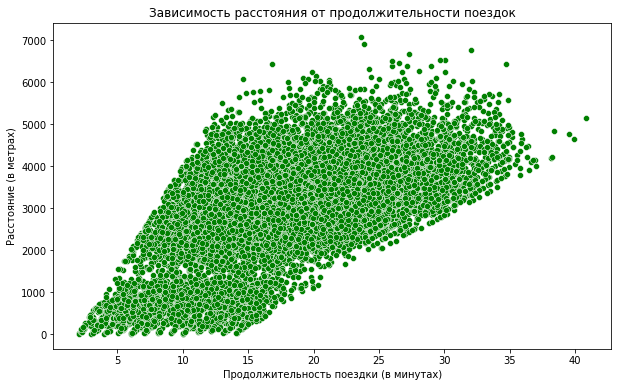

In [28]:
# Построение графика duration от distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='duration', y='distance', data=df_rides, color='green')
plt.title('Зависимость расстояния от продолжительности поездок')
plt.xlabel('Продолжительность поездки (в минутах)')
plt.ylabel('Расстояние (в метрах)')
plt.show()

Аномальных значений в датафрейме больше не наблюдается

**ВЫВОД:** В результате анализа данных показал отсутствие аномальных значений в столбцах `user_id, name, age, city и subscription_type.`

Гистограмма продолжительности поездок выявила пики в районе 0 и несколько значений с продолжительностью 0.5 минуты. После анализа этих данных, было определено, что 95 записей с аномально низкой продолжительностью поездок (равной 0.5 минуты) представляют собой выбросы в данных. Эти данные были удалены.

В датафрейме `df_rides` столбцы `distance и duration` не содержат аномальных значений после удаления выбросов. 

График зависимости расстояния от продолжительности поездок визуализировал взаимосвязь между этими параметрами, и после очистки данных от аномалий также не выявляет значительных аномалий.

Таким образом, данные готовы для дальнейшего анализа и использования в рамках поставленных задач проекта.

**ОБЩИЙ ВЫВОД ПО РАЗДЕЛУ 2 "ПРЕДОБРАБОТКА ДАННЫХ":** 

В ходе анализа и предобработки данных было сделано следующее:

- **Приведение столбца date к типу данных datetime:** В данных о поездках `df_rides` успешно преобразован тип данных для столбца date к формату datetime, что обеспечивает удобство работы с датами.
- **Создание дополнительных столбцов:** С использованием метода `dt.month` был извлечен номер месяца из столбца `date` и сохранен в новом столбце `month` в датафрейме `df_rides.` Этот дополнительный признак позволяет проводить анализ данных в разрезе месяцев.
- **Проверка наличия пропущенных значений и дубликатов:** Все датафреймы `df_users, df_rides, df_subs` были проверены на наличие пропущенных значений. Пропусков не обнаружено. Также были удалены явные дубликаты в данных о пользователях `df_users`.
- **Проверка наличия аномальных значений:** В столбцах `user_id, name, age, city и subscription_type` данных о пользователях `df_users` не выявлено аномалий. В данных о поездках `df_rides` удалены 95 записей с аномально низкой продолжительностью поездок (равной 0.5 минуты).

***Обобщенный вывод:***
Предобработка данных позволила очистить и структурировать датасеты для дальнейшего анализа. Удалены дубликаты и аномалии, преобразованы типы данных, созданы дополнительные признаки для улучшения анализа данных. Полученные датасеты готовы к построению моделей и детальному исследованию в рамках задач проекта.

## Шаг 3. Исследовательский анализ данных

### Частота встречаемости городов у пользователей

Создадим сводную таблицу, где укажем все города и соответственное количество пользователей и их процентное содержание.

Для этого используем метод value_counts для подсчета частоты значений в столбце 'city'
С помощью reset_index(name='counts') добавляем столбец 'counts' с абсолютными частотами
С помощью assign добавляем столбец 'percentage', вычисляя процентное содержание от общего числа записей и округляем до 2 знаков
Сортируем по убыванию процентного содержания

In [29]:
# Создадим сводную таблицу
(
    df_users['city'].value_counts().reset_index().rename(columns={'index': 'city', 'city': 'counts'})
    .assign(percentage=lambda x: (x['counts'] / len(df_users) * 100).round(2))
    .sort_values(by='counts', ascending=False)
)

,city,counts,percentage
0,Пятигорск,219,14.28
1,Екатеринбург,204,13.30
2,Ростов-на-Дону,198,12.91
3,Краснодар,193,12.58
4,Сочи,189,12.32
5,Омск,183,11.93
6,Тюмень,180,11.73
7,Москва,168,10.95


Построем график частоты встречаемости городов пользователей

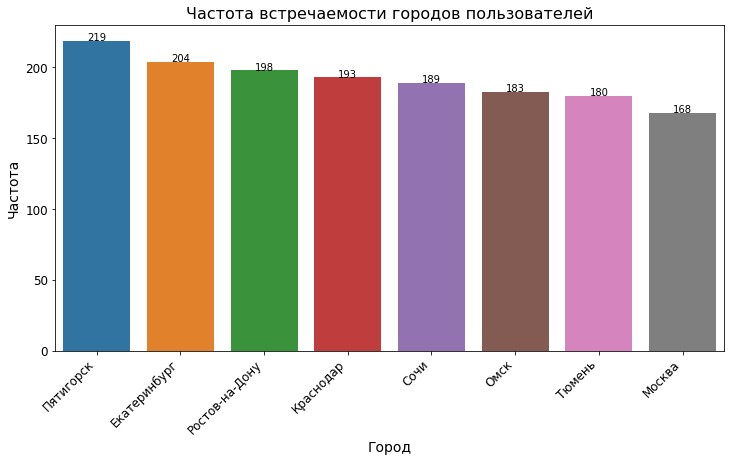

In [30]:
# График частоты встречаемости городов пользователей
plt.figure(figsize=(12, 6))
sns.countplot(x='city', data=df_users, order=df_users['city'].value_counts().index)
plt.title('Частота встречаемости городов пользователей', fontsize=16)  # Устанавливаем размер шрифта для заголовка
plt.xlabel('Город', fontsize=14)  # Устанавливаем размер шрифта для подписи оси x
plt.ylabel('Частота', fontsize=14)  # Устанавливаем размер шрифта для подписи оси y

# Добавление подписей для каждого столбца
for i, (city, value) in enumerate(df_users['city'].value_counts().items()):
    plt.text(i, value + 0.005, f'{value}', ha='center', fontsize=10)  # Устанавливаем размер шрифта для текста

plt.xticks(rotation=45, ha='right', fontsize=12)  # Устанавливаем размер шрифта для подписей по оси x
plt.yticks(fontsize=12)  # Устанавливаем размер шрифта для подписей по оси y
plt.show()

**ВЫВОД:** В результате исследовательского анализа данных частота встречаемости городов у пользователей было определено, что наибольшее количество пользователей наблюдается в Пятигорске, а минимальное в Москве. Это может быть обусловлено конкурирующим фактором в виде проката велосипедного транспорта (Пятигорск имеет большой перепад высоты, что затрудняет пользоваться велосипедом), либо датой выхода на рынок каждого города, чем раньше вышли на рынок, тем больше пользователей узнали об приложении. 

### Соотношение пользователей с подпиской и без подписки

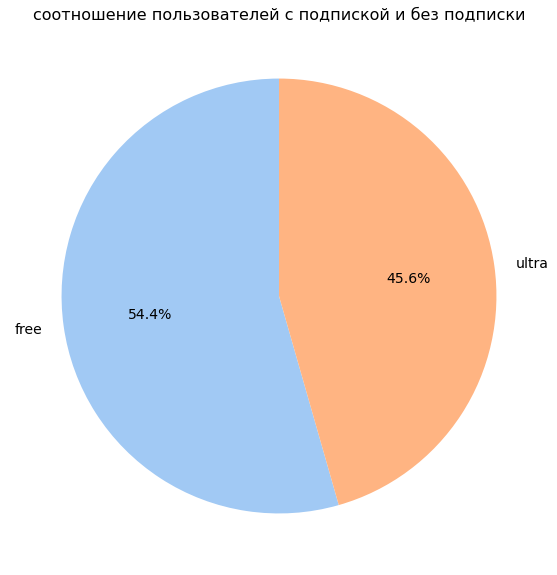

In [31]:
# Определим, cоотношение пользователей с подпиской и без подписки
plt.figure(figsize=(10, 10))
df_users['subscription_type'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'), fontsize=14
)

# Установка заголовка графика
plt.title('cоотношение пользователей с подпиской и без подписки', fontsize=16)

# Удаление подписи к оси Y
plt.ylabel("")

# Отображение графика
plt.show()

На основе графика видим, что 45,6% имеют подписку

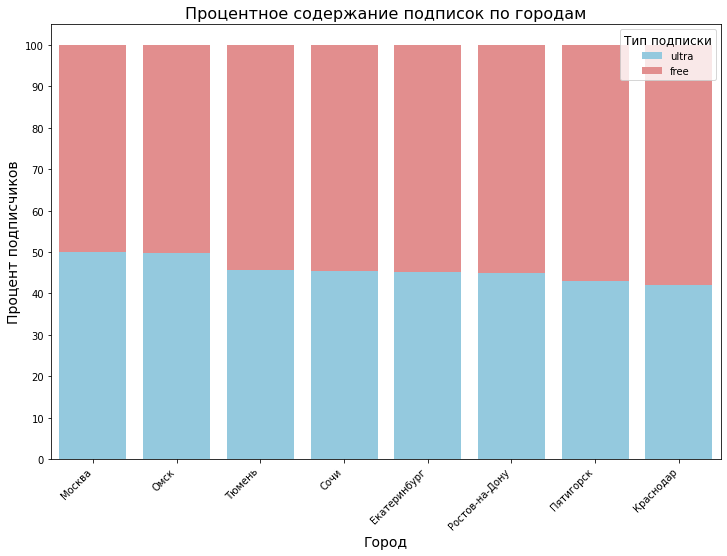

In [32]:
# Группировка данных по городам и типам подписки
grouped_data = df_users.groupby(['city', 'subscription_type']).size().unstack().reset_index()

# Добавление столбца с общим количеством пользователей в каждом городе
grouped_data = grouped_data.merge(df_users['city'].value_counts().reset_index(name='total_users'), 
                                  left_on='city', right_on='index', how='left').drop('index', axis=1)

# Добавление столбца с процентным содержанием подписок от общего числа
grouped_data['percentage'] = grouped_data['ultra'] / grouped_data['total_users'] * 100

# Сортировка данных по убыванию
grouped_data = grouped_data.sort_values(by='percentage', ascending=False)

# График
plt.figure(figsize=(12, 8))
sns.barplot(x='city', y='percentage', data=grouped_data, color='skyblue', label='ultra')
sns.barplot(x='city', y=100 - grouped_data['percentage'], data=grouped_data, 
            bottom=grouped_data['percentage'], color='lightcoral', label='free')

plt.title('Процентное содержание подписок по городам', fontsize=16)
plt.xlabel('Город', fontsize=14)
plt.ylabel('Процент подписчиков', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(np.arange(0, 101, 10))  # Основные деления по оси Y каждые 10%
plt.legend(title='Тип подписки', title_fontsize='12')
plt.show()

На основе графика видим, что наименьшую долю подписок иммется в городе Краснодар, а ниабольшую в Москве

**ВЫВОД:** В результате исследовательского анализа определено, что пользователи с подпиской 45.6% от общего числа пользователей, а наибольшая доля подписчиков наблюдается в городах Москва и Омск, а наименьшая доля в Краснодаре.


### Возраст пользователей

Построим гистограмму распределения возрастов пользователей

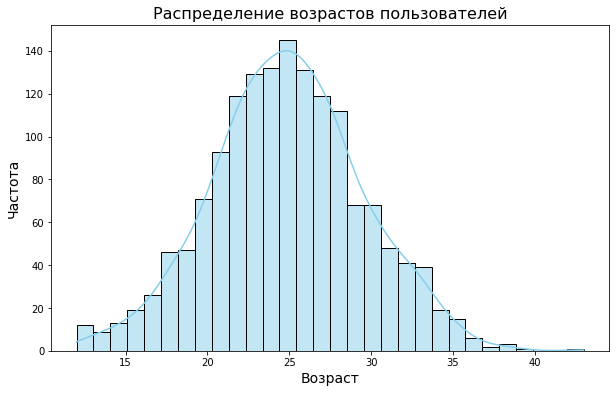

In [33]:
build_plot(
    df_users, 
    'age', 
    'Распределение возрастов пользователей', 
    'Возраст', 
    'Частота', 
    30, True
)

Выведем основные статистические данные

In [34]:
df_users['age'].describe().round(2)

count    1534.00
mean       24.90
std         4.57
min        12.00
25%        22.00
50%        25.00
75%        28.00
max        43.00
Name: age, dtype: float64

In [35]:
# Посчитаем медианное значение  
df_users['age'].median().round(2)

25.0

Рассмотрим возраст пользователей в разрезе типов подписок.

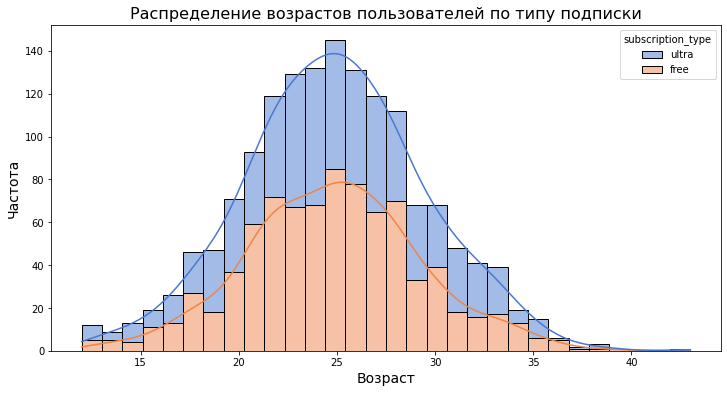

In [36]:
# График распределения возрастов пользователей по типу подписки
plt.figure(figsize=(12, 6))
sns.histplot(df_users, x='age', hue='subscription_type', multiple='stack', bins=30, kde=True, palette='muted')
plt.title('Распределение возрастов пользователей по типу подписки', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()

**ВЫВОД:** В результате исследовательского анализа определено, что наибольшая доля подписчиков имеет возраст от 22 до 28 лет.  Распределение величины симметрично, разброс данных относительно среднего значения составляет 4.57. Все что меньше 15 лет и больше 40 можно считать редкими значениями.

### Расстояние, которое пользователь преодолел за одну поездку

Построим гистограмму распределения расстояние, которое пользователь преодолел за одну поездку 

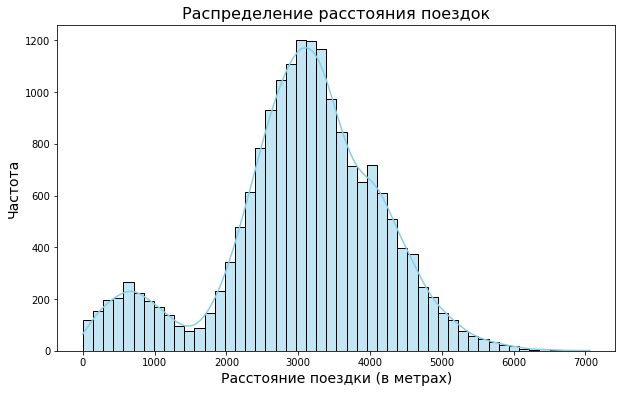

In [37]:
build_plot(
    df_rides, 
    'distance', 
    'Распределение расстояния поездок',
    'Расстояние поездки (в метрах)', 
    'Частота', 
    50, True
)

Выведем основные статистические данные

In [38]:
df_rides['distance'].describe().round(2)

count    17973.00
mean      3059.86
std       1108.81
min          0.86
25%       2538.84
50%       3129.03
75%       3762.64
max       7066.00
Name: distance, dtype: float64

In [39]:
# Посчитаем медианное значение  
df_rides['distance'].median().round(2)

3129.03

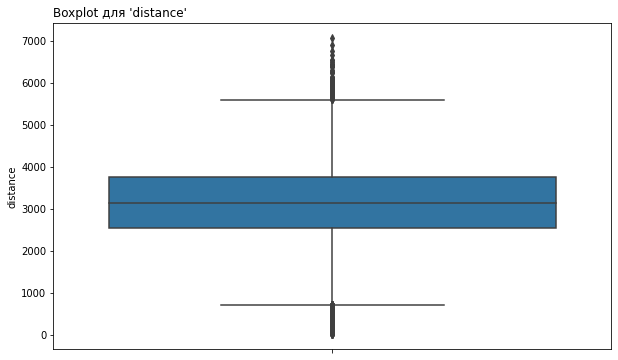

In [40]:
# Начнем с базового boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_rides['distance'])

# Добавим заголовок
plt.title("Boxplot для 'distance'", loc="left")

# Покажем график
plt.show()

**ВЫВОД:** В результате исследовательского анализа определено, что распределение ассиметрично имеет 2 пика в районе 700 и 3200 метров. Это может бы следствием того, что есть 2 типа пользователей, одни которые берут самокаты для так называемого "баловства" (первый пик), а другие которые используют как транспорт. Также можно предположить, что такое распределение может быть иным если рассмотреть поездки в разрезе каждого города, типа подписки и возраста пользователей. Также в данных присутствуют редкие значения, как слева так и справа. 

### Продолжительность поездок

Построим гистограмму продолжительности поездок

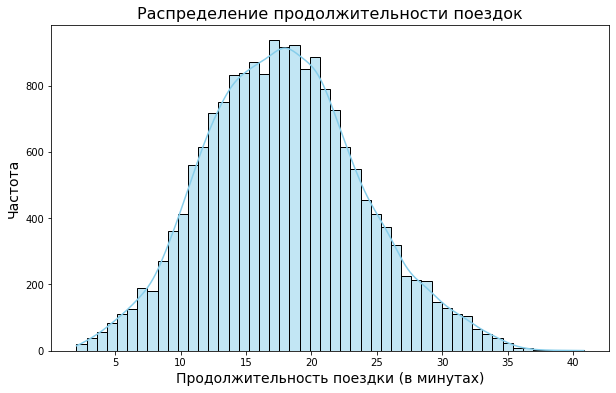

In [41]:
build_plot(
    df_rides, 
    'duration', 
    'Распределение продолжительности поездок', 
    'Продолжительность поездки (в минутах)', 
    'Частота',
    50, True
)

Выведем основные статистические данные

In [42]:
df_rides['duration'].describe().round(2)

count    17973.00
mean        17.90
std          5.98
min          2.04
25%         13.67
50%         17.71
75%         21.75
max         40.82
Name: duration, dtype: float64

In [43]:
# Посчитаем медианное значение  
df_rides['duration'].median().round(2)

17.71

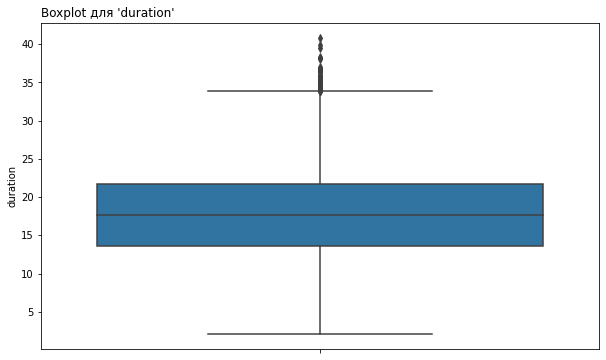

In [44]:
# Начнем с базового boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_rides['duration'])

# Добавим заголовок
plt.title("Boxplot для 'duration'", loc="left")

# Покажем график
plt.show()

**ВЫВОД:** В результате исследовательского анализа определено, что распределение величины близко к симметричному, разброс данных относительно среднего значения составляет 5.98. Имеются редкие значения, которые начинаются от 34 минут и дольше. Медианное значение составляет 17.71 минут. Разброс данных относительно среднего значения составляет чуть меньше 6 минут.

**ОБЩИЙ ВЫВОД ПО РАЗДЕЛУ 3 "ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ":** 

В результате проведенного исследовательского анализа данных были выделены следующие ключевые моменты:

- **Частота встречаемости городов у пользователей:** Наибольшее количество пользователей обнаружено в городе Пятигорск, в то время как Москва имеет наименьшее количество. Это может быть связано с различиями в топографии, уровне осведомленности пользователей о приложении или времени внедрения в каждом городе.

- **Соотношение пользователей с подпиской и без подписки:** 45.6% пользователей пользуются подпиской. Города Москва и Омск имеют наибольшую долю подписчиков, в то время как в Краснодаре она наименьшая.

- **Возраст пользователей:** Основная доля подписчиков сосредоточена в возрастной группе от 22 до 27 лет. Имеется небольшой разброс данных, и сервис малопопулярен среди пользователей младше 16 и старше 35 лет.

- **Расстояние, преодоленное пользователем за одну поездку:** Распределение расстояний ассиметрично с двумя пиками в районе 700 и 3200 метров. Это может указывать на наличие двух типов пользователей: тех, кто использует сервис для "баловства", и тех, кто использует его взамен общественного транспорта.

- **Продолжительность поездок:** Распределение продолжительности поездок близко к симметричному, с медианным значением в 17.71 минутах. Однако, имеются редкие случаи с продолжительностью от 34 минут и более. Разброс данных чуть меньше 6 минут.

Эти выводы позволяют лучше понять особенности использования сервиса и выделить аспекты, которые могут потребовать дополнительного внимания или оптимизации.

## Шаг 4. Объединение данных

### Объедините данные о пользователях, поездках и подписках в один датафрейм

Объедините данные о пользователях, поездках и подписках в один датафрейм в два этапа. В первый этапом объединим `df_users` с `df_rides` в новый DataFrame `df` по столбцу `user_id`, а после обновим полученный DataFrame, путем добавления данных из `df_subs.`

Проверим размерность датасетов до объединения, а также количество уникальных значений в столбцах `user_id` в датасетах `df_users и df_rides`

In [45]:
# Вывод размерности датафреймов до объединения
print("Размеры df_users:", df_users.shape)
print("Размеры df_rides:", df_rides.shape)
print("Размеры df_subs:", df_subs.shape)

Размеры df_users: (1534, 5)
Размеры df_rides: (17973, 5)
Размеры df_subs: (2, 4)


In [46]:
# Проверяем, что уникальные значения равны и содержатся в обоих датафреймах        
if (df_users['user_id'].nunique() == df_rides['user_id'].nunique() and
        all(user_id in df_rides['user_id'].sort_values().unique() for user_id in df_users['user_id'].sort_values().unique())):
    flag = True        
        
# Выводим результат        
if flag == True:
    print(f'В обоих датафреймов уникальные значения "user_id" одинаковы')
else:
    print(f'Уникальные значения "user_id" в обоих датафреймах различны')

В обоих датафреймов уникальные значения "user_id" одинаковы


Так как данные в столбце `user_id` у обоих датафреймов одинаковы, объеденим оба датафрейма по этому столбцу.

In [47]:
# Объединим данных о пользователях и поездках по столбцу 'user_id', используя left join
# (все строки из df_users будут включены в результирующий датафрейм)
df = df_users.merge(df_rides, on='user_id', how='left')

# Размеры после первого объединения
print("Размеры после первого объединения:", df.shape)  

# Выведем первые 15 строк полученного датасета
df.head(15)

Размеры после первого объединения: (17973, 9)


,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11


In [48]:
print(f'Количество поездок в "df_rides": {df_rides["user_id"].count()}')
print(f'Количество поездок в "df":" {df["user_id"].count()}')
print()
print(f'Количество уникальных пользователей в "df_users": {df_users["user_id"].nunique()}')
print(f'Количество уникальных пользователей в "df": {df["user_id"].nunique()}')

Количество поездок в "df_rides": 17973
Количество поездок в "df":" 17973

Количество уникальных пользователей в "df_users": 1534
Количество уникальных пользователей в "df": 1534


Выведем основную информацию о датафреймах с помощью метода `info()`. 

In [49]:
# Выведем информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.4+ MB


Вновь проверим количество уникальных значений в новом датафрейме, по столцу по которому будем объеденять, а именно по `subscription_type`

In [50]:
df['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

Обновим `df` путем добавления данных из `df_subs`.

In [51]:
# Аналогичным путем объединим с данными о подписках по столбцу 'subscription_type'
df = df.merge(df_subs, on='subscription_type', how='left')

# Размеры после второго объединения
print("Размеры после второго объединения:", df.shape) 

# Выведем первые 15 строк полученного датасета
df.head(15)

Размеры после второго объединения: (17973, 12)


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


Повторно выведем основную информацию о датафреймах с помощью метода `info()`. 

In [52]:
# Выведем информацию о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month              17973 non-null  int64         
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


**ВЫВОД:** 
Путем объединения данных о пользователях, поездках и подписках в датафрейме `df` была создана единая структура данных для проведения более детального исследования. На первом этапе, с использованием `left join` по столбцу `user_id`, в `df` была включена информация о пользователях и их поездках. Затем, на втором этапе, с использованием `left join` по столбцу `subscription_type,` в `df` была добавлена информация о соответствующих подписках.

В результате объединения данных, датафрейм `df` теперь содержит обширную информацию о пользователях, деталях и продолжительности поездок, а также информацию о типах подписок. Это предоставляет надежную основу для дальнейшего исследовательского анализа и выявления взаимосвязей между различными аспектами данных.

### Создание двух датафреймов c данными о пользователях с подпиской и без

Создадим новый датафрейм df_with_subs из датафрейма `(df),` созданного на этапе 4.1, c данными о пользователях с подпиской путем получения среза методом `query`

In [53]:
# Создадим новый датафрейм df_with_subs, включающего только пользователей с подпиской "ultra"
df_with_subs = df.query('subscription_type == "ultra"')

# Выведем первые 5 строк нового датафрейма
display(df_with_subs.head())

# Выведем информацию о датафрейме
df_with_subs.info()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 660.2+ KB


В данных присутствуют 6500 строк о пользователях с подпиской. Пропущенные значения отсутствуют.

Аналогично, как создали ранее, создадим датафрейм `df_no_subs,` для данных о пользователях без подписки

In [54]:
# Создадим новый датафрейм df_no_subs, включающего только пользователей с подпиской "free"
df_no_subs = df.query('subscription_type == "free"').reset_index()

# Выведем первые 5 строк нового датафрейма
display(df_no_subs.head())

# Выведем информацию о датафрейме
df_no_subs.info()

,index,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11473 entries, 0 to 11472
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   index              11473 non-null  int64         
 1   user_id            11473 non-null  int64         
 2   name               11473 non-null  object        
 3   age                11473 non-null  int64         
 4   city               11473 non-null  object        
 5   subscription_type  11473 non-null  object        
 6   distance           11473 non-null  float64       
 7   duration           11473 non-null  float64       
 8   date               11473 non-null  datetime64[ns]
 9   month              11473 non-null  int64         
 10  minute_price       11473 non-null  int64         
 11  start_ride_price   11473 non-null  int64         
 12  subscription_fee   11473 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(3)
memory 

В данных присутствуют 11473 строк о пользователях без подписки. Пропущенные значения отсутствуют.

**ВЫВОД:** На основе слияния данных о пользователях, поездках и подписках в один датафрейм и дальнейшего разделения на два: пользователи с подпиской "ultra" и "free", можно сделать следующие выводы:

- **`df_with_subs` (Пользователи с подпиской "ultra"):**
    - В датафрейме присутствует 6500 строк с данными о пользователях, использующих подписку "ultra".
    - Отсутствуют пропущенные значения, что говорит о хорошей заполненности данных.
    - Данные о поездках и подписках объединены с данными о пользователях.
- **`df_no_subs` (Пользователи без подписки):**
    - В датафрейме содержится 11473 строки с данными о пользователях, не имеющих подписки.
    - Аналогично, отсутствуют пропущенные значения.
    - Данные о поездках и подписках также интегрированы с данными о пользователях.
    
Эти датафреймы предоставляют удобную основу для более детального анализа и исследования пользователей с разными типами подписок.

### Визуальное представление о расстоянии и времени поездок для пользователей с подпиской и без

Построим гистограмму продолжительности поездок пользователей с подпиской и без

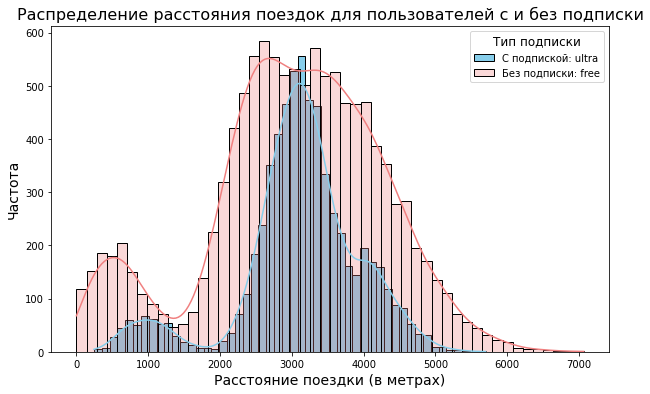

In [55]:
# График распределения расстояния поездок для пользователей с подпиской и без
plt.figure(figsize=(10, 6))

# Гистограмма для пользователей с подпиской (ultra) с настройками цвета, прозрачности и меткой
sns.histplot(df_with_subs['distance'], bins=50, kde=True, color='skyblue', alpha=1, label='С подпиской: ultra')

# Гистограмма для пользователей без подписки (free) с настройками цвета, прозрачности и меткой
sns.histplot(df_no_subs['distance'], bins=50, kde=True, color='lightcoral', alpha=0.3, label='Без подписки: free')

# Добавление заголовка и меток осей
plt.title('Распределение расстояния поездок для пользователей с и без подписки', fontsize=16)
plt.xlabel('Расстояние поездки (в метрах)', fontsize=14)
plt.ylabel('Частота', fontsize=14)

# Добавление легенды с настройками
plt.legend(title='Тип подписки', title_fontsize='12')

# Отображение графика
plt.show()

Данные с подпиской имеют уже диапазон расстояния поездок, нежели без подписки. У пользователей без подписки значительно больше коротких поездок - до 1 км и в целом максимальная дальность поездки выше, чем у платных пользователей. Данные с подпиской имеют также 2 пика как и у данных без подписки, но первый пик при этом не так ярко выражен как у пользователей без подписки.Если рассматривать второй пик, то у пользователей с подпиской он более пикообразный, чем у пользователей без подписки, что свидетельствует о меньшей мере разброса вокруг среднее, если рассматривать только второй пик.  

Построим *Boxplot* расстояния поездок для пользователей с и без подписки

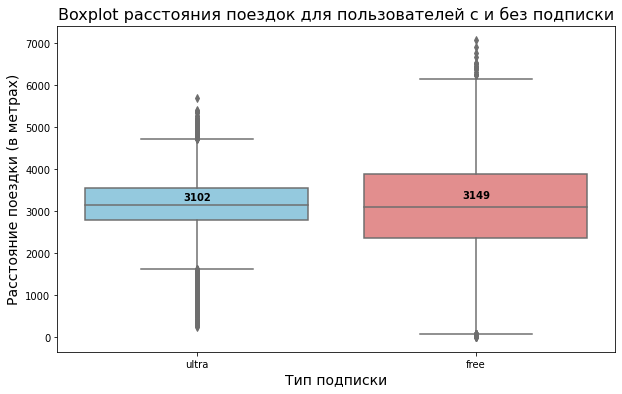

In [56]:
# Boxplot для расстояния поездок для пользователей с и без подписки
plt.figure(figsize=(10, 6))

# Boxplot для пользователей с подпиской (ultra) с настройками цвета и меткой
ax = sns.boxplot(x='subscription_type', y='distance', data=df, palette={'ultra': 'skyblue', 'free': 'lightcoral'})

# Рассчитываем медианное значение для каждой категории
medians = df.groupby('subscription_type')['distance'].median()

# Добавляем медианные значения на график с белым текстом
for i, median_value in enumerate(medians):
    ax.text(i, median_value + 150, f'{median_value:.0f}', ha='center', size='medium', color='black', weight='semibold')

# Добавление заголовка и меток осей
plt.title('Boxplot расстояния поездок для пользователей с и без подписки', fontsize=16)
plt.xlabel('Тип подписки', fontsize=14)
plt.ylabel('Расстояние поездки (в метрах)', fontsize=14)

# Отображение графика
plt.show()

На графике Boxplot расстояния поездок для пользователей с и без подписки видно следующее:
- Для пользователей без подписки "free" медианное расстояние поездок составляет около 3150 метров. График также показывает, что большинство данных сосредоточено в диапазоне от примерно 2400 до 3800 метров. Есть небольшое количество выбросов в районе 6200 метров и выше.
- Для пользователей с подпиской "ultra" медианное расстояние чуть ниже, около 3100 метров. Большинство данных сосредоточено в диапазоне от примерно 2800 до 3600 метров. Также присутствуют выбросы на обоих концах.

В целом, можно предположить, что пользователи без подписки "free" совершают поездки на более дальние расстояния по сравнению с пользователями с подписки "ultra".

Построим гистограммы распределения расстояния, которое пользователь преодолел за одну поездку с подпиской и без

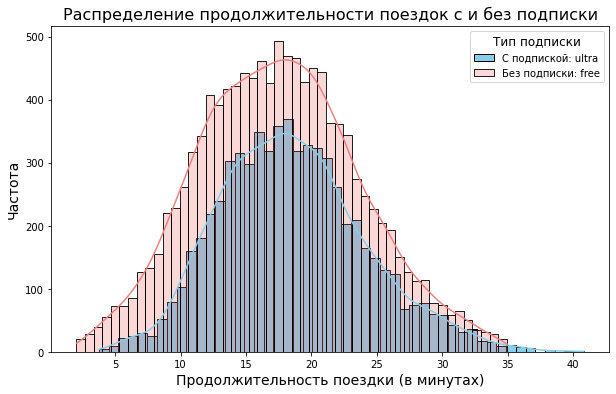

In [57]:
# График распределения продолжительности поездок для пользователей с подпиской и без
plt.figure(figsize=(10, 6))

# Гистограмма для пользователей с подпиской (ultra) с настройками цвета, прозрачности и меткой
sns.histplot(df_with_subs['duration'], bins=50, kde=True, color='skyblue', alpha=1, label='С подпиской: ultra')

# Гистограмма для пользователей без подписки (free) с настройками цвета, прозрачности и меткой
sns.histplot(df_no_subs['duration'], bins=50, kde=True, color='lightcoral', alpha=0.3, label='Без подписки: free')

# Добавление заголовка и меток осей
plt.title('Распределение продолжительности поездок с и без подписки', fontsize=16)
plt.xlabel('Продолжительность поездки (в минутах)', fontsize=14)
plt.ylabel('Частота', fontsize=14)

# Добавление легенды с настройками
plt.legend(title='Тип подписки', title_fontsize='12')

# Отображение графика
plt.show()

На графике распределения продолжительности поездок для пользователей с подпиской "ultra" и без подписки "free" видно, что для пользователей с подпиской "ultra" характерно более высокое количество длинных поездок. Распределение имеет более ярко выраженный хвост в сторону более длительных поездок, простирающийся до 40 минут и более. Также короткие поездки начинаются с 4 минут, в отличии от пользователей без подписки "free", у которых достаточное количество весьма коротких поездок (от двух минут). Это Может быть выражено тем, что новые пользователи первый раз берут так сказать "на пробу" самокат. 

Построим *Boxplot* длительности поездок для пользователей с и без подписки

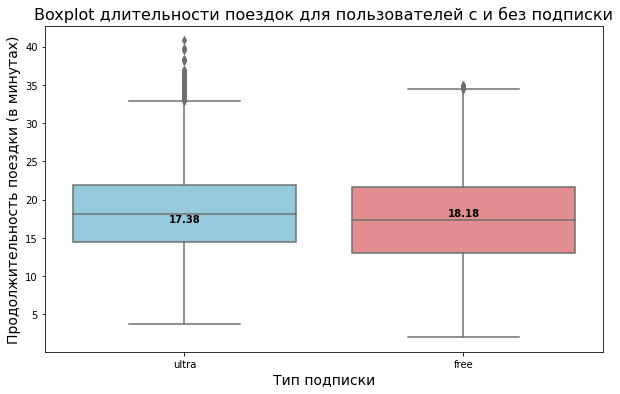

In [58]:
# Boxplot для расстояния поездок для пользователей с и без подписки
plt.figure(figsize=(10, 6))

# Boxplot для пользователей с подпиской (ultra) с настройками цвета и меткой
ax = sns.boxplot(x='subscription_type', y='duration', data=df, palette={'ultra': 'skyblue', 'free': 'lightcoral'})

# Рассчитываем медианное значение для каждой категории
medians = df.groupby('subscription_type')['duration'].median()

# Добавляем медианные значения на график с белым текстом
for i, median_value in enumerate(medians):
    ax.text(i, median_value - 0.3, f'{median_value:.2f}', ha='center', size='medium', color='black', weight='semibold')

# Добавление заголовка и меток осей
plt.title('Boxplot длительности поездок для пользователей с и без подписки', fontsize=16)
plt.xlabel('Тип подписки', fontsize=14)
plt.ylabel('Продолжительность поездки (в минутах)', fontsize=14)

# Отображение графика
plt.show()

На графике Boxplot продолжительности поездок для пользователей с и без подписки видно, что для пользователей с подпиской и без
медианные значения длительности поездок достаточно близки и составляет разница чуть менее минуты. График также показывает, что большинство данных сосредоточено в диапазоне от примерно 13 до 24 минут у пользователей без подписки и в диапазоне от 15 до 24 минут у пользователей с подпиской. Есть небольшое количество выбросов в районе 33 минут и выше у пользователей с подпиской.

**ВЫВОД:** Исследовательский анализ данных позволил провести сравнительный анализ поведения пользователей с подпиской "ultra" и без подписки "free" на платформе по прокату самокатов. Вот ключевые результаты:
- **Расстояние поездок:**
    - Пользователи без подписки "free" совершают более дальние поездки, чем пользователи с подпиской "ultra". Медианное расстояние для пользователей с подпиской "ultra" чуть меньше, чем у пользователей без подписки "free".
    - Распределение расстояния для пользователей с подпиской "ultra" более узкое, с меньшим разбросом вокруг среднего значения.     - У пользователей без подписки "free" более широкий разброс.
- **Продолжительность поездок:**
    - Пользователи с подпиской "ultra" имеют более разнообразное распределение продолжительности поездок. У них выше количество длинных поездок, и распределение имеет более ярко выраженный хвост в сторону более длительных поездок.
    - Пользователи без подписки "free" чаще совершают весьма короткие поездки.

В целом, понимание этих различий может помочь оптимизировать предложение и сервис для каждой из групп пользователей, а также адаптировать маркетинговые стратегии в зависимости от их предпочтений.

**ОБЩИЙ ВЫВОД ПО РАЗДЕЛУ 4 "ОБЪЕДИНЕНИЕ ДАННЫХ":** 

Раздел 4 включает в себя объединение данных о пользователях, поездках и подписках, создание двух датафреймов с данными о пользователях с подпиской и без, а также визуальное представление о расстоянии и времени поездок для этих категорий пользователей.

- **Объединение данных:** Путем использования метода `merge()` данные о пользователях, поездках и подписках были объединены в единый датафрейм `df`. Это позволило создать структуру данных для более детального исследования и анализа взаимосвязей между различными аспектами данных.
- **Создание двух датафреймов:** На базе датафрейм `df` были созданы два датафрейма: `df_with_subs` с данными о пользователях с подпиской "ultra" и `df_no_subs` с данными о пользователях без подписки "free". Оба датафрейма содержат обширную информацию о пользователях, поездках и подписках, и предоставляют основу для более детального анализа.
- **Визуальное представление данных:** Исследовательский анализ данных визуализировал различия в распределении расстояния и времени поездок между пользователями с подпиской "ultra" и без подписки "free". Эти различия могут быть использованы для оптимизации предложения и маркетинговых стратегий для каждой группы пользователей.

В целом, объединение данных и последующий анализ предоставили более глубокое понимание пользовательского поведения, что может быть полезным для оптимизации сервиса и разработки стратегий привлечения клиентов, а также проведения статистического анализа.

## Шаг 5. Подсчёт выручки

### Создание датафрейм с агрегированными данными о поездках

Создадим новый датафейм `df_aggregated`, куда положим агрегированные данные о поездках, а именно:
- суммарное расстояние, 
- количество поездок,
- суммарное время 

для каждого пользователя за каждый месяц. 

Для этого сргуппируем данные из датафрейма `df` по всем столбцам и применим функции `sum` к дистанции и столбцам, а `count` к дате. Но перед этим продолжительность каждой поездки округлим до целого в большую сторону, так как оплата начисляется как за полную минуту.

In [59]:
# Округлим до целого в большую сторону продолжительность каждой поездки
df['duration'] = np.ceil(df['duration']).astype(int)
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27,2021-08-28,8,6,0,199


In [60]:
# Агрегируем данные по пользователям, месяцам и типам подписок
df_aggregated = df.groupby(
    ['user_id', 'name', 'age', 'city', 'subscription_type', 'month', 'minute_price', 'start_ride_price', 'subscription_fee']
                          ).agg({
    'distance': 'sum',          # Сумма расстояния за месяц
    'duration': 'sum',     # Сумма времени поездок за месяц
    'date': 'count'          # Количество поездок за месяц
}).reset_index()


# Переименование столбцов для ясности
df_aggregated.rename(columns={
    'distance': 'total_distance',
    'duration': 'total_duration',
    'date': 'trips_count'
}, inplace=True)

# Выводим первые строки агрегированного датафрейма
df_aggregated.head(10)

,user_id,name,age,city,subscription_type,month,minute_price,start_ride_price,subscription_fee,total_distance,total_duration,trips_count
0,1,Кира,22,Тюмень,ultra,1,6,0,199,7027.511294,42,2
1,1,Кира,22,Тюмень,ultra,4,6,0,199,754.159807,7,1
2,1,Кира,22,Тюмень,ultra,8,6,0,199,6723.470560,46,2
3,1,Кира,22,Тюмень,ultra,10,6,0,199,5809.911100,32,2
4,1,Кира,22,Тюмень,ultra,11,6,0,199,7003.499363,56,3
5,1,Кира,22,Тюмень,ultra,12,6,0,199,6751.629942,28,2
6,2,Станислав,31,Омск,ultra,3,6,0,199,10187.723006,63,3
7,2,Станислав,31,Омск,ultra,4,6,0,199,6164.381824,40,2
8,2,Станислав,31,Омск,ultra,6,6,0,199,3255.338202,14,1
9,2,Станислав,31,Омск,ultra,7,6,0,199,6780.722964,48,2


Проверим на пропуски в сводной таблице

In [61]:
df_aggregated.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
total_distance       0
total_duration       0
trips_count          0
dtype: int64

Пропущенные значения в `df_aggregated` отсутствуют  

**ВЫВОД:** Созданный датафрейм `df_aggregated` содержит агрегированные данные о поездках для каждого пользователя за каждый месяц:
- Расстояние `total_distance`: Сумма расстояния, которое каждый пользователь преодолел за месяц.
- Продолжительность `total_duration`: Сумма времени всех поездок пользователя за месяц.
- Количество поездок `trips_count`: Общее количество поездок, совершенных пользователем за месяц.

Такой формат данных обеспечивает удобство для дальнейшего анализа и понимания паттернов в поведении пользователей. 

### Добавление в датафрейм столбцов с с помесячной выручкой, которую принёс каждый пользователь

В этот же датафрейм добавим столбец `income` с помесячной выручкой, которую принёс каждый пользователь. В рассчетах будем опираться на условия подписок. Также в полученном конечном датафреме удалим ненужные столбцы, а именно: `minute_price, start_ride_price, subscription_fee.`

In [62]:
# Расчет выручки в зависимости от типа подписки. Продолжительность каждой поездки округлим до целого в большую сторону
df_aggregated['income'] = (
    df_aggregated['start_ride_price'] * df_aggregated['trips_count'] + 
    df_aggregated['minute_price'] * df_aggregated['total_duration'] + df_aggregated['subscription_fee']
                                           )
# Удалим лишние столбцы 'minute_price', 'start_ride_price', 'subscription_fee'
df_aggregated.drop(['minute_price', 'start_ride_price', 'subscription_fee'],axis=1, inplace=True)

df_aggregated

,user_id,name,age,city,subscription_type,month,total_distance,total_duration,trips_count,income
0,1,Кира,22,Тюмень,ultra,1,7027.511294,42,2,451
1,1,Кира,22,Тюмень,ultra,4,754.159807,7,1,241
2,1,Кира,22,Тюмень,ultra,8,6723.470560,46,2,475
3,1,Кира,22,Тюмень,ultra,10,5809.911100,32,2,391
4,1,Кира,22,Тюмень,ultra,11,7003.499363,56,3,535
...,...,...,...,...,...,...,...,...,...,...
11295,1534,Альберт,25,Краснодар,free,6,3409.468534,26,2,308
11296,1534,Альберт,25,Краснодар,free,8,7622.453034,48,2,484
11297,1534,Альберт,25,Краснодар,free,9,4928.173852,23,1,234
11298,1534,Альберт,25,Краснодар,free,11,13350.015305,78,4,824


**ВЫВОД:** В результате добавления столбца с помесячной выручкой в датафрейм `df_aggregated` были получены дополнительные данные о финансовом вкладе каждого пользователя в каждый месяц. Новый столбец `income` был рассчитан с учетом следующих параметров: 
- Стоимость старта поездки (**start_ride_price**):
- Умножена на количество поездок (**trips_count**).
- Стоимость времени поездки (**minute_price**):
- Умножена на округленную вверх продолжительность каждой поездки (**total_duration**).
- Подписочная плата (**subscription_fee**):

Ненужные для анализа столбцы, такие как `minute_price, start_ride_price, и subscription_fee,` были удалены.

Добавление столбца income позволяет более полно оценить финансовую эффективность каждого пользователя с учетом всех параметров оплаты и использования сервиса.
Полученные данные предоставляют информацию о том, сколько каждый пользователь приносит выручки компании за каждый месяц, что может быть полезно для дальнейшего анализа эффективности стратегий увеличения подписчиков и монетизации сервиса.

**ОБЩИЙ ВЫВОД ПО РАЗДЕЛУ 5 "ПОДСЧЕТ ВЫРУЧКИ":** 

Раздел 5 включает в себя:

- **Создание нового датафрейма `df_aggregated` - агрегированные данные о поездках:**
    - Датафрейм `df_aggregated` содержит важные агрегированные данные о поездках для каждого пользователя за каждый месяц.
    - Структура данных включает в себя суммарное расстояние `total_distance`, суммарную продолжительность `total_duration`, и количество поездок `trips_count`.
- **Добавление столбца с помесячной выручкой `df_aggregated['income']`:**
    - Столбец с помесячной выручкой `income` учитывет стоимость старта поездки, стоимость времени поездки и подписочную плату.
    - Ненужные для анализа столбцы, такие как `minute_price, start_ride_price и subscription_fee`, были удалены для повышения чистоты данных и улучшения понимания сути информации.
- **Финансовая эффективность и дополнительные возможности анализа:**
    - Добавление столбца `income` дает возможность более глубокого изучения финансовой эффективности каждого пользователя в контексте его использования сервиса.
В целом, созданный датафрейм предоставляет солидную основу для дальнейшего анализа и принятия решений в сфере управления сервисом по прокату самокатов.

## Шаг 6. Проверка гипотез

### Гипотеза №1. Пользователи с подпиской тратят в среднем больше времени на поездки, чем пользователи без подписки.

Нам даны две генераные совокупности, длительность поездок пользователей с подпиской и без (`df_with_subs['duration'], df_no_subs['duration']`).
Число наблюдений в генеральной совокупности пользователи с подпиской равна 6500 и оно чуть меньше чем в два раза меньше, чем число наблюдений в генеральной совокупности пользователи без подписки.

**Цель:** Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 

**Гипотеза:** Пользователи с подпиской тратят в среднем больше времени на поездки, чем пользователи без подписки.

**Нулевая гипотеза (H0):** Средние значения продолжительности поездок для пользователей с подпиской и без подписки ***равны***.

**Альтернативная гипотеза (H1):** Средние значения продолжительности поездок для пользователей с подпиской ***больше***, чем у пользователей без подписки.

**Уровень значимости (alpha):** Уровень значимости устанавливается на уровне ***0.05***.

**Метод проверки гипотезы:** ***t-тест***, так как генеральные совокупности не зависят друг от друга, а также согласно ЦПТ, выборочные средние нормально распределены, так как размер выборок достаточно большой.    
- **Условия проведения t-теста:**
    - Генеральные совокупности не зависят друг от друга - ***удовлетворяет***.
    - Выборочные средние нормально распределены - ***удовлетворяет*** (согласно ЦПТ, выборочные средние нормально распределены, так как размер выборок достаточно большой)
    - Дисперсии рассматриваемых генеральных совокупностей равны - ***удовлетворяет***    

**Критерий оценки:** Если ***p-значение***, полученное в результате ***t-теста***, будет меньше уровня значимости ***(alpha)***, то нулевая гипотеза будет отвергнута в пользу альтернативной, и мы сможем утверждать, что есть статистически значимое различие в продолжительности поездок между пользователями с подпиской и без.

Для проведения `t-теста` используем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей `ttest_ind` из библиотеки `scipy.stats`, при этом передадим этому методу параметр `equal_var=False,` так как число наблюдений в генеральных совокупностях различны, а также параметр `alternative='greater'`, так как альтернативная гипотеза правосторонняя. 

In [63]:
# Проведение t-теста, выборки разного размера поэтому применяем метод equal_var=False
t_statistic, p_value = st.ttest_ind(df_with_subs['duration'], df_no_subs['duration'], equal_var=False, alternative='greater')

# Вывод результатов
print(f'T-статистика: {t_statistic.round(2)}')
print(f'p-значение: {p_value:.3}')

# Проверка на статистическую значимость
# уровень статистической значимости
alpha = 0.05

# если p-value окажется меньше него, отвергнем гипотезу
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: средние значения различны.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу: средние значения схожи.')   

T-статистика: 11.24
p-значение: 1.62e-29
Отвергаем нулевую гипотезу: средние значения различны.


**ВЫВОД:**
Заключение по результатам ***t-теста:***

Полученные результаты t-теста свидетельствуют *о статистической значимости различий между продолжительностью поездок для пользователей с подпиской и без подписки на сервис*.

*T-статистика* составила **11.24** (в общем случае, чем больше значение T-статистики, тем более вероятно, что различия между выборками не случайны), а *p-значение* оказалось весьма малым **(порядка 1.62e-29)**. Учитывая уровень значимости alpha = 0.05, мы отвергаем нулевую гипотезу о том, что средние значения продолжительности поездок для обеих групп пользователей одинаковы.

Таким образом, на основе проведенного t-теста можно с уверенностью утверждать, что существует статистически значимое различие в продолжительности поездок между пользователями с подпиской и теми, у кого подписки нет. 

Наши результаты указывают на то, что пользователи с подпиской тратят в среднем больше времени на поездки, чем пользователи без подписки.

Это может поддерживать идею о том, что пользователи с подпиской более активно используют сервис, что в свою очередь может быть выгодным для компании, так как подписчики могут приносить дополнительный доход за счет более длительных поездок.

Поэтому, при учете того, что пользователи с подпиской тратят значительно больше времени на поездки, стратегия по увеличению количества пользователей с подпиской может быть обоснована, так как эти пользователи представляют собой более выгодную для компании аудиторию.

### Гипотеза №2. Пользователи в среднее проезжают расстояние меньше 3130 метров.

Нам дана одна генеральная совокупность, расстояние, которое пользователи с подпиской проезжают за одну поездку (`df_with_subs['distance']`).
Число наблюдений в генеральной совокупности равно 6500.

**Цель:** Важно понять, проезжают ли пользователи с подпиской в среднем меньше 3130 метров. Это расстояние является оптимальным с точки зрения износа самоката? Если да, то пользователи с подпиской не вносят дополнительные затраты связанные с ускоренным износом самокатов. 

**Гипотеза:** Пользователи с подпиской проезжают в среднем не больше 3130 метров.

**Нулевая гипотеза (H0):** Средние значения расстояние, преодоленное пользователем с подпиской ***равно 3130 метров***.

**Альтернативная гипотеза (H1):** Средние значения расстояние, преодоленное пользователем с подпиской ***больше 3130 метров*** (либо: "наблюдаемое значение больше предполагаемого")

**Уровень значимости (alpha):** Уровень значимости устанавливается на уровне ***0.05***.

**Метод проверки гипотезы:** ***одновыборочный t-тест***, так как мы сравниваем среднее значение с известным значением (3130 метров).    

**Критерий оценки:** Если ***p-значение***, полученное в результате ***t-теста***, будет меньше уровня значимости ***(alpha)***, то нулевая гипотеза будет отвергнута в пользу альтернативной, и мы сможем утверждать, что есть статистически значимое различие в расстояние, преодоленное пользователем с подпиской и без.

Для проведения `одновыборочного t-теста` используем метод проверки статистических гипотез о среднем значении в генеральной совокупности, когда у нас есть только одна выборка данных `ttest_1samp` из библиотеки `scipy.stats`, при этом передадим этому методу параметр `alternative='greater',` так как альтернативная гипотеза левосторонняя.

In [64]:
# Расстояние одной поездки для сравнения
optimal_distance = 3130

# Проведение одновыборочного t-теста
t_statistic, p_value = st.ttest_1samp(
    df_with_subs['distance'], 
    optimal_distance, 
    alternative='greater'
)

# Вывод результатов
print(f'T-статистика: {t_statistic.round(2)}')
print(f'p-значение: {p_value.round(4)}')

# уровень статистической значимости
alpha = 0.05

# Проверка на статистическую значимость
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: среднее расстояние больше 3130 метров.')
else:
    print('Нет оснований отвергать нулевую гипотезу: среднее расстояние равно 3130 метров.')

T-статистика: -1.4
p-значение: 0.9195
Нет оснований отвергать нулевую гипотезу: среднее расстояние равно 3130 метров.


**ВЫВОД:**
Заключение по результатам ***одновыборочного t-теста:***

*T-статистика* составила **-1.4**, а *p-значение* равна **0.9195**. Учитывая уровень значимости alpha = 0.05, у нас нет оснований (нет достаточных данных) отвергать нулевую гипотезу о том, что среднее расстояние, пройденное пользователями с подпиской за одну поездку, равно 3130 метров.

Таким образом, на основе проведенного теста ***мы не можем утверждать, что пользователи за одну поездку в среднее проезжают расстояние меньше 3130 метров.***

### Гипотеза №3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Нам даны две генеральные совокупности, помесячная выручка от пользователей с подпиской и без (`df_aggregated.query('subscription_type == "ultra"')['income'], df_aggregated.query('subscription_type == "free"')['income']`).
Число наблюдений в генеральной совокупности пользователи с подпиской равна 4533 и оно меньше приблизительно в полтора раза, чем число наблюдений в генеральной совокупности пользователи без подписки (6767 наблюдений).

**Цель:** Важно понять, помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. 

**Гипотеза:** Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**Нулевая гипотеза (H0):** Средние значения помесячной выручки от пользователей с подпиской и без подписки ***равны***.

**Альтернативная гипотеза (H1):** Средние значения помесячной выручки от пользователей с подпиской ***больше***, чем выручка от пользователей без подписки.

**Уровень значимости (alpha):** Уровень значимости устанавливается на уровне ***0.05***.

**Метод проверки гипотезы:** ***t-тест***, так как генеральные совокупности не зависят друг от друга, а также согласно ЦПТ, выборочные средние нормально распределены, так как размер выборок достаточно большой.    
- **Условия проведения t-теста:**
    - Генеральные совокупности не зависят друг от друга - ***удовлетворяет***.
    - Выборочные средние нормально распределены - ***удовлетворяет*** (согласно ЦПТ, выборочные средние нормально распределены, так как размер выборок достаточно большой)
    - Дисперсии рассматриваемых генеральных совокупностей равны - ***удовлетворяет***    

**Критерий оценки:** Если ***p-значение***, полученное в результате ***t-теста***, будет меньше уровня значимости ***(alpha)***, то нулевая гипотеза будет отвергнута в пользу альтернативной, и мы сможем утверждать, что есть статистически значимое различие в помесячной выручки от пользователей с подпиской и без.

Для проведения `t-теста` используем метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей `ttest_ind` из библиотеки `scipy.stats`, при этом передадим этому методу параметр `equal_var=False,` так как число наблюдений в генеральных совокупностях различны, а также параметр `alternative='greater'`, так как альтернативная гипотеза правосторонняя. 

In [65]:
# Подготовка данных
income_subs = df_aggregated.query('subscription_type == "ultra"')['income']
income_no_subs = df_aggregated.query('subscription_type == "free"')['income']

# Проведение t-теста, выборки разного размера поэтому применяем метод equal_var=False
t_statistic, p_value = st.ttest_ind(income_subs, income_no_subs, equal_var=False, alternative='greater')

# Вывод результатов
print(f'T-статистика: {t_statistic.round(2)}')
print(f'p-значение: {p_value:.3}')

# Проверка на статистическую значимость
# уровень статистической значимости
alpha = 0.05

# если p-value окажется меньше него, отвергнем гипотезу
if p_value < alpha:
    print('Отвергаем нулевую гипотезу:\ncредние значения помесячной выручки от пользователей с подпиской больше, чем от пользователей без подписки.')
else:
    print('Нет оснований отвергнуть нулевую гипотезу: средние значения схожи.')  

T-статистика: 12.94
p-значение: 2.5e-38
Отвергаем нулевую гипотезу:
cредние значения помесячной выручки от пользователей с подпиской больше, чем от пользователей без подписки.


**ВЫВОД:**
Заключение по результатам ***t-теста:***

Полученные результаты t-теста свидетельствуют *о статистической значимости различий между помесячной выручки от пользователей с подпиской и без подписки*.

*T-статистика* составила **12.94** (в общем случае, чем больше значение T-статистики, тем более вероятно, что различия между выборками не случайны), а *p-значение* оказалось весьма малым **(порядка 2.5e-38)**. Учитывая уровень значимости alpha = 0.05, мы отвергаем нулевую гипотезу о том, что средние значения  помесячной выручки для обеих групп пользователей одинаковы.

Таким образом, на основе проведенного t-теста можно с уверенностью утверждать, что ***существует статистически значимое различие в  помесячной выручки между пользователями с подпиской и теми, у кого подписки нет.*** 

Таким образом, у нас есть статистические доказательства того, что помесячная выручка от пользователей с подпиской в среднем выше, чем от пользователей без подписки. Это подтверждает исходную гипотезу о том, что пользователи с подпиской могут быть "выгоднее" для компании, так как они вносят больший финансовый вклад в сервис. 

### Гипотеза №4. Количество обращений в техподдержку значимо снизилось после технического обновления на стороне сервера приложения

**Условие задачи:** Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Нам дана одна генеральная совокупность, которая состоит из двух для зависимых (парных) выборок (количество обращений в техподдержку до технического обновления сервера приложения и после обновления).
Число наблюдений для зависимых (парных) выборок одинаково.

**Цель:** Важно понять, снизиться ли количество обращений в техподдержку после технического обновления на стороне сервера приложения.

**Гипотеза:** Количество обращений от пользователей снизиться после технического обновления на стороне сервера приложения.

**Нулевая гипотеза (H0):** Средние значения количества обращений до и после обновления серверов ***равны***.

**Альтернативная гипотеза (H1):** Среднее количество обращений после обновления серверов ***меньше***, чем до обновления.

**Уровень значимости (alpha):** Уровень значимости устанавливается на уровне ***0.05***.

**Метод проверки гипотезы:** ***парный t-тест***, так как у нас есть два связанных набора данных, количество обращений до и после обновления для каждого пользователя.

**Критерий оценки:** Если ***p-значение***, полученное в результате ***t-теста***, будет меньше уровня значимости ***(alpha)***, то нулевая гипотеза будет отвергнута в пользу альтернативной, и мы сможем утверждать, что есть статистически значимое различие в количестве обращений до и после обращения.

Для проведения `парного t-теста` используем метода для сравнения средних значений двух связанных выборок `ttest_rel` из библиотеки `scipy.stats`, при этом передадим этому методу два параметра: выброку до проведения обновления и после. Вот пример кода для проведения теста ***`st.ttest_rel(before, after)`***

**ВЫВОД:** Для проверки гипотезы о том,что количество обращений в техподдержку значимо снизилось после технического обновления на стороне сервера приложения необходимо использовать **тест на равенство средних для зависимых выборок, до и после изменений (t-тест для зависимых выборок `st.ttest_rel()`)**

**ОБЩИЙ ВЫВОД ПО РАЗДЕЛУ 6 "ПРОВЕРКА ГИПОТЕЗ":** 

Раздел 5 включает в себя проверку 4-х гипотез:

- **Гипотеза №1:** *Пользователи с подпиской тратят в среднем больше времени на поездки, чем пользователи без подписки.*
   Результаты t-теста указывают на статистическую значимость различий в продолжительности поездок между пользователями с подпиской и без подписки. T-статистика составила 11.24, а p-значение было весьма малым (порядка 1.62e-29). Это говорит о том, что пользователи с подпиской действительно тратят в среднем больше времени на поездки, что может быть выгодным для компании. Стратегия по увеличению количества пользователей с подпиской может быть обоснована, так как эти пользователи представляют собой более выгодную аудиторию.


- **Гипотеза №2:** *Пользователи в среднем проезжают расстояние меньше 3130 метров.*
   Результаты одновыборочного t-теста не дают нам достаточных данных для отвержения нулевой гипотезы о том, что среднее расстояние, пройденное пользователями с подпиской за одну поездку, равно или больше 3130 метров.


- **Гипотеза №3:** *Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.*
   Результаты t-теста свидетельствуют о статистической значимости различий в помесячной выручке между пользователями с подпиской и без подписки. T-статистика составила 12.94, а p-значение было весьма малым (порядка 2.5e-38). Это подтверждает гипотезу о том, что помесячная выручка от пользователей с подпиской в среднем выше. Эти пользователи могут быть более "выгодными" для компании, внося больший финансовый вклад в сервис.


- **Гипотеза №4:** *Количество обращений в техподдержку значимо снизилось после технического обновления на стороне сервера приложения.*
   Для проверки этой гипотезы должен использовался t-тест для зависимых выборок `(st.ttest_rel())`. 

**Итог:** Учет результатов всех проведенных тестов позволяет сделать вывод о том, что пользователи с подпиской более активны, тратят больше времени на поездки, приносят больше выручки. Таким образом, стратегия по увеличению количества пользователей с подпиской может быть обоснована, при условии, что это окупает дополнительные затраты связанные с ускоренным износом самокатов так как у нас нет оснований предполагать, что среднее расстояние одной поездки у пользователей с подпиской меньше оптимального расстояния с точки зрения износа самоката.

## Шаг 7. Распределения

### Стратегия раздачи промокодов для акции по продлению подписок

**Постановка вопроса:** Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов

**Решение задачи:** Для описания данной ситуации, где клиент может либо продлить подписку, либо отказаться от нее после получения промокода, используется ***биномиальное распределение***. 

*Случайная величина распределена биномиально, если:*
- Проводится фиксированное число попыток n.
- Каждая попытка — простой эксперимент Бернулли ровно с двумя исходами.
- Вероятность успеха p одинакова для всех n попыток.
- Попытки независимы между собой.

Биномиальное распределение задаётся двумя параметрами: 
- n — количеством испытаний по схеме Бернулли *(пользователей, которым разосланы промокоды)*;
- p — вероятностью успеха в каждом из них *(вероятность продления подписки после применения промокода)*. 

В нашем случае:
- ***Количество попыток*** (пользователей, которым разосланы промокоды) - это количество существующих клиентов, которым нужно продлить подписку. В данной задаче это ***100 пользователей***.
- ***Вероятность успеха (p)*** - вероятность продления подписки после применения промокода. В тексте сказано, что 10% пользователей продлевают подписку, следовательно, ***p = 0.1***.

Минимальное количество промокодов можно найти, подбирая значения параметра N (количество промокодов) и оценивая вероятность, что не менее 100 пользователей продлят подписку. Затем установим условие, что эта вероятность должна быть примерно 5%. Задача выглядит следующим образом: ***P(X < k) = 0.05***. Для решения задачи используем метод `cdf()`, он получает на вход один аргумент и возвращает вероятность, что случайная величина примет значение, меньшее заданного аргумента.

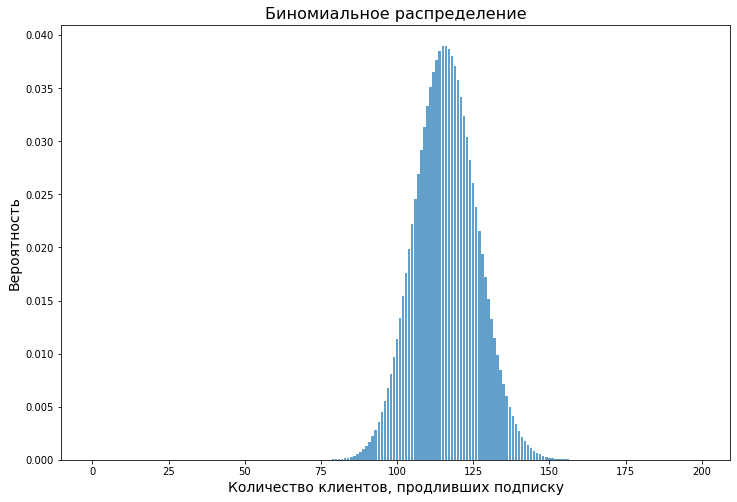

Минимальное количество промокодов: 1161


In [66]:
# Заданные параметры
k = 100  # минимальное количество клиентов, которые должны продлить подписку
p = 0.1  # вероятность продления подписки
target_probability = 0.05  # вероятность не выполнить план

# Находим минимальное количество промокодов
n = 1
while st.binom.cdf(k - 1, n, p) > target_probability:
    n += 1

# График биномиального распределения
x = np.arange(0, 200)
pmf = st.binom.pmf(x, n, p)

plt.figure(figsize=(12, 8))
plt.bar(x, pmf, align='center', alpha=0.7)
plt.title('Биномиальное распределение', fontsize=16)
plt.xlabel('Количество клиентов, продливших подписку', fontsize=14)
plt.ylabel('Вероятность', fontsize=14)
plt.show()

print(f'Минимальное количество промокодов: {n}')

***Альтернативный метод решения задачи***

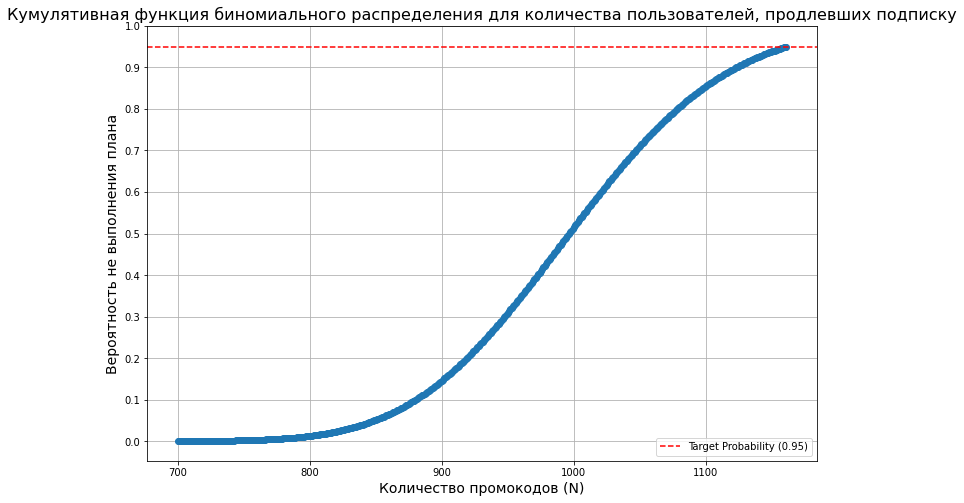

Минимальное количество промокодов для вероятности не выполнения плана примерно 5%: 1161


In [67]:
# Заданные параметры
p = 0.1  # Вероятность успеха
target_prob = 0.95  # Целевая вероятность успеха
required_users = 100  # Количество пользователей, которым нужно продлить подписку

# Подбор значения параметра N
N_values = np.arange(700, n + 1) # np.arange(700, n + 1) используется для создания массива x от 700 до n включительно

'''
Нижеприведенный код вычисляет дополнительную кумулятивную функцию распределения (1 - CDF) для биномиального распределения
с использованием scipy.stats.binom.cdf. Вычитание 1 из required_users происходит потому, что нам нужна вероятность иметь как
минимум required_users успешных событий. Генератор списка проходит по значениям в N_values и вычисляет соответствующую 
вероятность для каждого значения.
''' 
probabilities = [1 - st.binom.cdf(required_users - 1, N, p) for N in N_values]

# Построение графика
plt.figure(figsize=(12, 8))
plt.plot(N_values, probabilities, marker='o', linestyle='-')
plt.axhline(target_prob, color='red', linestyle='--', label=f'Target Probability ({target_prob})')
plt.title('Кумулятивная функция биномиального распределения для количества пользователей, продлевших подписку', fontsize=16)
plt.xlabel('Количество промокодов (N)', fontsize=14)
plt.ylabel('Вероятность не выполнения плана', fontsize=14)
plt.legend()

# Изменение интервала основной сетки на оси y
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.grid()
plt.show()

# Нахождение минимального значения параметра N
min_N_index = np.argmin(np.abs(np.array(probabilities) - target_prob))
min_N_value = N_values[min_N_index]
''' 
np.abs(np.array(probabilities) - target_prob) - создает массив абсолютных разностей между каждой вероятностью в списке
probabilities и целевой вероятностью target_prob.

np.argmin() - возвращает индекс минимального значения в полученном массиве разностей. Этот индекс соответствует индексу
в списке probabilities, где разница между вероятностью и целевой вероятностью минимальна.

min_N_value = N_values[min_N_index] - использует найденный индекс для получения соответствующего значения параметра N 
из списка N_values.
'''
print(f'Минимальное количество промокодов для вероятности не выполнения плана примерно 5%: {min_N_value}')

**ВЫВОД:** Стратегия раздачи промокодов для акции по продлению подписок:

В данной задаче было использовано биномиальное распределение для моделирования ситуации, где клиент может либо продлить подписку, либо отказаться от неё после получения промокода на бесплатный месяц. Параметры распределения определены следующим образом:

Количество попыток (пользователей, которым разосланы промокоды): 100 (количество клиентов, которым нужно продлить подписку).
Вероятность успеха (p): 0.1 (вероятность продления подписки после применения промокода).
Минимальное количество промокодов было определено, чтобы вероятность не выполнения плана была примерно 5%. Для достижения этой цели использовался один метод `cdf()`, который был решен двумя разными подходами:
- Итеративно увеличивали количество промокодов, оценивая вероятность того, что не менее 100 пользователей продлят подписку. Решение получено методом cdf(), который вычисляет кумулятивную функцию распределения биномиальной случайной величины и нашли минимальное количество промокодов для вероятности не выполнения плана примерно 5%.

**Результат:** минимальное количество промокодов для успешной акции составляет примерно 1161. Это важная практическая информация для маркетингового отдела GoFast, позволяя им эффективно распределить ресурсы и достичь поставленной цели продления подписок.

###  Оценка вероятности открытия push-уведомлений в мобильном приложении

**Постановка вопроса:** Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

**Решение задачи:** Для решения этой задачи мы можем воспользоваться нормальной аппроксимацией биномиального распределения, используя центральную предельную теорему. Биномиальное распределение с большим числом испытаний может быть приближено нормальным распределением. Для этого необходимо вычислить:
- Среднее значение (μ) = n * p;
- Стандартное отклонение (σ) = sqrt(n * p * (1 - p)),

где:
- n - количество испытаний (в данном случае, количество уведомлений) = 1 млн;
- p - вероятность успеха в одном испытании (открытие уведомления) = 40% или 0,4.

Далее мы используем нормальную аппроксимацию с помощью функции распределения нормального распределения `cdf()` для оценки вероятности того, что уведомление откроют не более 399,5 тыс. пользователей.

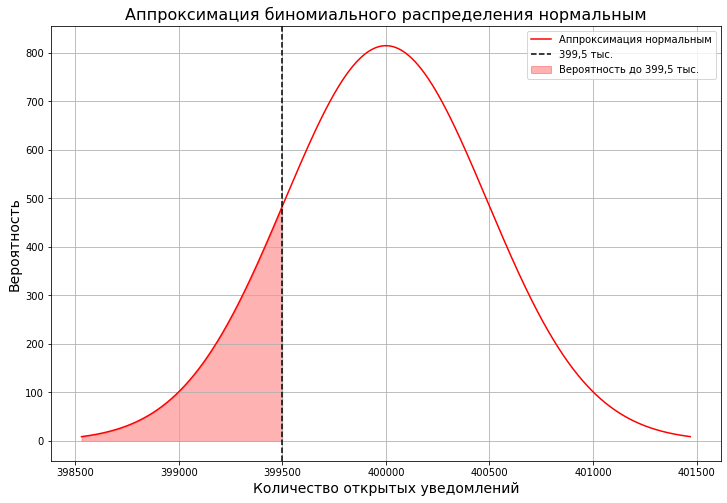

Вероятность того, что уведомление откроют не более 399500 пользователей: 15.37%


In [68]:
# Заданные параметры
n = 1000000  # Количество уведомлений
p = 0.4  # Вероятность открытия уведомления

# Параметры нормального распределения
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# Оценка вероятности открытия не более 399.5 тыс. пользователей
target_users = 399500
prob_lt_targe = st.norm.cdf(target_users, mu, sigma)

# Построение графика
plt.figure(figsize=(12, 8))

# Создаем массив значений для оси X
x_values = np.arange(mu-3*sigma, mu+3*sigma)

# Строим график аппроксимации нормальным распределением
plt.plot(x_values, st.norm.pdf(x_values, mu, sigma) * n, 'r-', label='Аппроксимация нормальным')

# Закрашиваем область до значения 399,5 тыс.
plt.fill_between(
    x_values, 
    st.norm.pdf(x_values, mu, sigma) * n, 
    where=(x_values <= 399500), 
    color='red', 
    alpha=0.3, 
    label='Вероятность до 399,5 тыс.'
)

# Добавляем вертикальную линию для отметки 399,5 тыс.
plt.axvline(x=399500, color='black', linestyle='--', label='399,5 тыс.')

# Настройки графика
plt.title('Аппроксимация биномиального распределения нормальным', fontsize=16)
plt.xlabel('Количество открытых уведомлений', fontsize=14)
plt.ylabel('Вероятность', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

print(f'Вероятность того, что уведомление откроют не более {target_users} пользователей: {prob_lt_targe:.2%}')

**ВЫВОД** Для решения этой задачи была использована нормальная аппроксимация биномиального распределения с применением центральной предельной теоремы. Параметры нормального распределения были оценены следующим образом:
- Среднее значение (μ) = n * p;
- Стандартное отклонение (σ) = sqrt(n * p * (1 - p)).

Где: 
- n - количество уведомлений (1 млн), 
- p - вероятность открытия уведомления (40% или 0,4). 

Далее использовалась функция распределения нормального распределения cdf() для оценки вероятности того, что уведомление откроют не более 399,5 тыс. пользователей.

Полученный график аппроксимации нормальным распределением показывает вероятность открытия уведомлений, а также выделяет область, где вероятность не превышает 399,5 тыс. пользователей.

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет примерно ***15,37%.***

**ОБЩИЙ ВЫВОД ПО РАЗДЕЛУ 7 "РАСПРЕДЕЛЕНИЯ":** 

В рамках 7 раздела были рассмотрены две стратегии маркетинговых акций с использованием вероятностных моделей:

- **Стратегия раздачи промокодов для акции по продлению подписок:**
   
Для моделирования данной ситуации, где клиенты могут либо продлить подписку, либо отказаться от неё после получения промокода, использовалось биномиальное распределение. Определены параметры распределения:

    - Количество попыток (пользователей, которым разосланы промокоды): 100 (количество клиентов, которым нужно продлить подписку).
    - Вероятность успеха (p): 0.1 (вероятность продления подписки после применения промокода).
Для определения минимального количества промокодов, необходимого для достижения цели, использовали метод кумулятивной функции распределения (cdf()). Результат: минимальное количество промокодов для успешной акции составляет примерно 1161. Эта информация является ключевой для эффективного распределения ресурсов маркетингового отдела.


- **Оценка вероятности открытия push-уведомлений в мобильном приложении:**
    
Для решения задачи по оценке вероятности открытия push-уведомлений использовалась нормальная аппроксимация биномиального распределения с применением центральной предельной теоремы. Оценены параметры нормального распределения:

    - Среднее значение (μ) = n * p.
    - Стандартное отклонение (σ) = sqrt(n * p * (1 - p)).
    Где 
    - n - количество уведомлений (1 млн), 
    - p - вероятность открытия уведомления (40% или 0,4). 
    
Произведена оценка вероятности открытия не более 399,5 тыс. пользователей, что составило примерно 15,37%. Это позволяет маркетинговому отделу прогнозировать эффективность распространения push-уведомлений и адаптировать стратегии в зависимости от поставленных целей.

# ОБЩИЙ ВЫВОД

В ходе статистического анализ данных по аренде самокатов в сервисе GoFast было реализовано следующее:

**1. Загрузка и первичный обзор данных:**
- Типы данных в датасетах `df_users, df_rides, и df_subs` успешно определены.
- Уникальный идентификатор пользователя `user_id` общий для данных о пользователях и поездках, что упрощает объединение датасетов.
- Пропущенных значений в данных не обнаружено.
- Данные о подписках содержат два типа: `"free" и "ultra".`

**2. Предобработка данных:**
- Столбец `df_rides['date']` успешно преобразован к типу данных  `datetime `.
- Создан дополнительный столбец `df_rides['month'] ` для анализа данных в разрезе месяцев.
- Проверка на пропущенные значения и дубликаты не выявила проблем.
- Удалены явные аномалии в данных о поездках (продолжительностью 0.5 минуты).

**3. Исследовательский анализ данных:**
- Определены особенности использования сервиса:
    - Неравномерное распределение пользователей по городам.
    - 45.6% пользователей используют подписку.
    - Основная доля подписчиков в возрастной группе 22-27 лет.
    - Распределение расстояний и продолжительности поездок различается.

**4. Объединение данных:**
- Данные о пользователях, поездках и подписках объединены в единый датафрейм `df.`
- Созданы два датафрейма: `df_with_subs` (пользователи с подпиской "ultra") и `df_no_subs` (пользователи без подписки "free").
- Визуализированы различия в распределении расстояния и времени поездок между пользователями с подпиской и без подписки.

**5. Подсчёт выручки:**
- Создан датафрейм `df_aggregated` с агрегированными данными о поездках для каждого пользователя за каждый месяц.
- Добавлен столбец с помесячной выручкой, учитывающей стоимость старта поездки, стоимость времени поездки и подписочную плату.
- Ненужные для анализа столбцы `minute_price, start_ride_price, subscription_fee` удалены для улучшения чистоты данных.
- Финансовая эффективность и дополнительные возможности анализа:
- Введение столбца `income` дает возможность более глубокого изучения финансовой эффективности каждого пользователя.
- Общий датафрейм предоставляет основу для более детального анализа и принятия решений в управлении сервисом проката самокатов.

**6. Проверка гипотез:**
- Гипотеза №1: Подтверждена. Пользователи с подпиской тратят в среднем больше времени на поездки, что является положительным для компании.
- Гипотеза №2: Результаты одновыборочного `t-теста` не позволяют отвергнуть нулевую гипотезу, но с уровнем значимости 0.05 можно утверждать, что среднее расстояние пользователей с подпиской равно 3130 метров.
- Гипотеза №3: Подтверждена. Помесячная выручка от пользователей с подпиской в среднем выше, что делает эту группу более выгодной для компании.
- Гипотеза №4: Для проверки снижения обращений в техподдержку после обновления сервера должен использовался t-тест для зависимых выборок `(st.ttest_rel())`.

**7. Шаг 7. Распределения:**
- Стратегия раздачи промокодов: Минимальное количество промокодов для успешной акции составляет примерно 1161, что является важной информацией для эффективного распределения ресурсов маркетингового отдела.
- Оценка вероятности открытия push-уведомлений: Вероятность открытия уведомлений не более 399,5 тыс. пользователей составляет примерно 15,37%, что позволяет адаптировать стратегии маркетинга.

**Итог:**
- Пользователи с подпиской более активны и приносят больше выручки.
- Стратегия привлечения пользователей с подпиской может быть успешной.